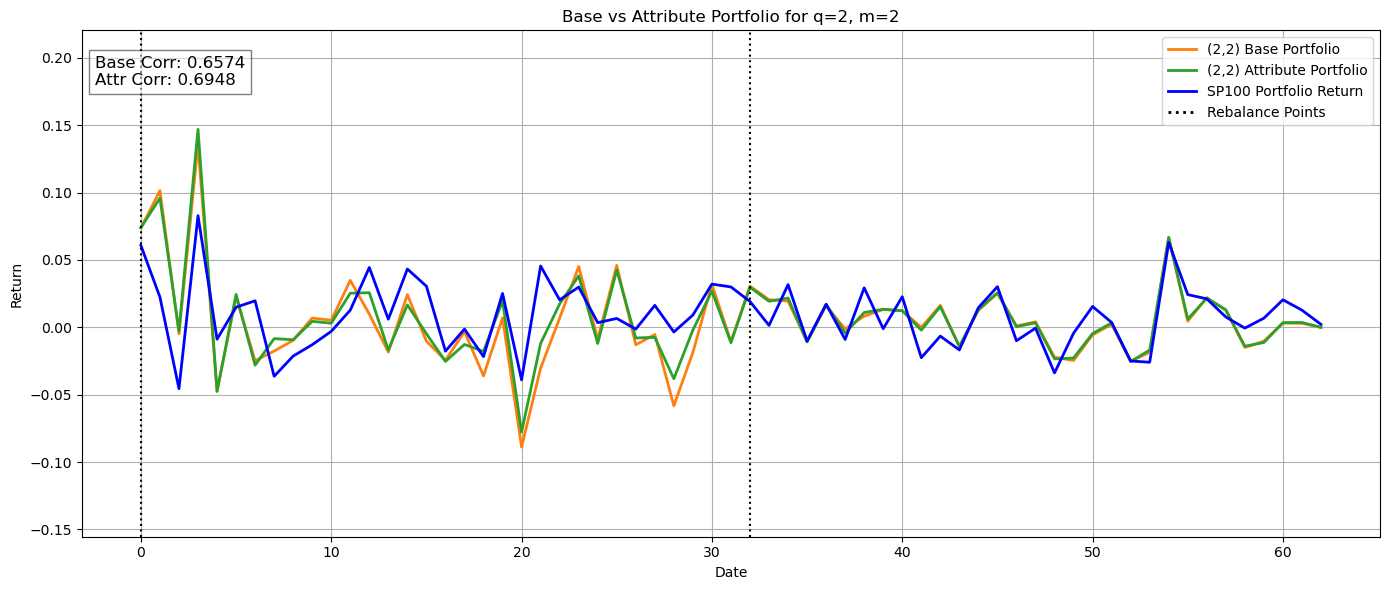

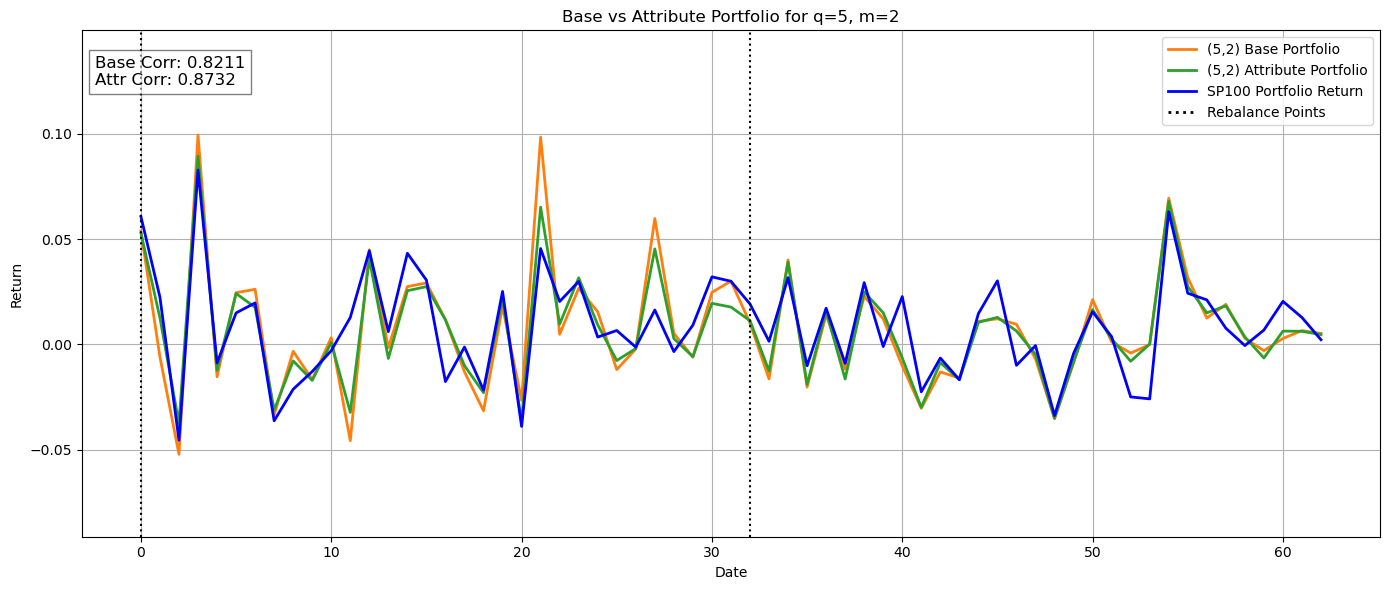

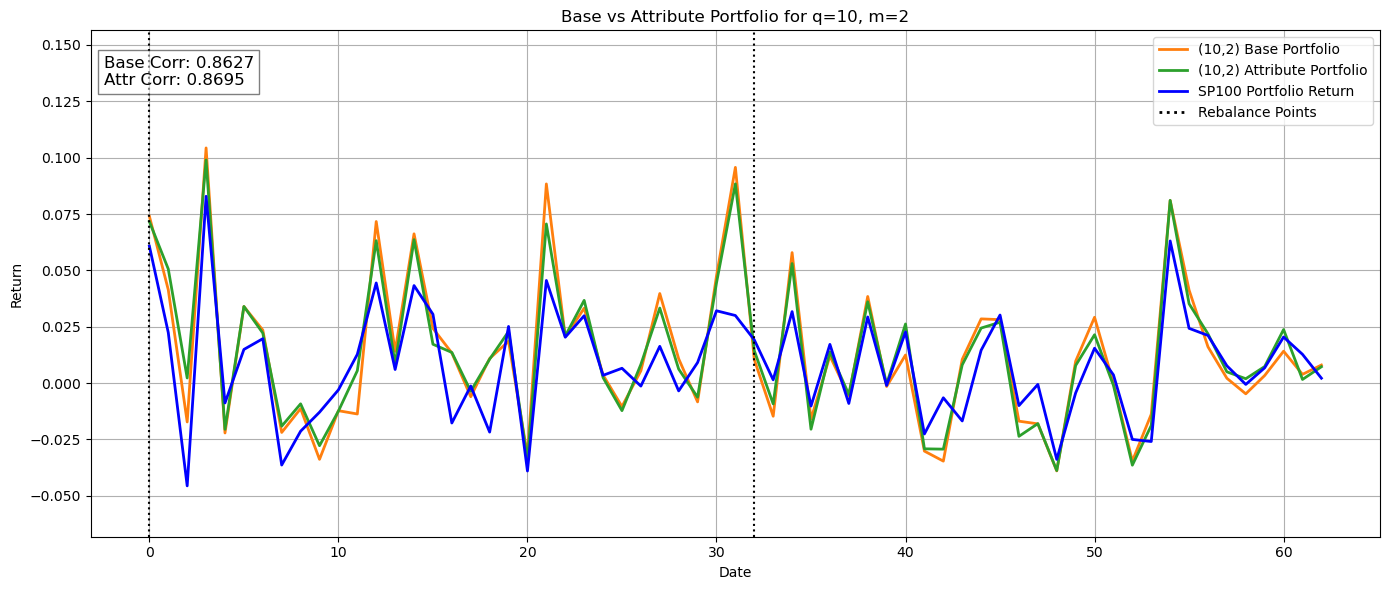

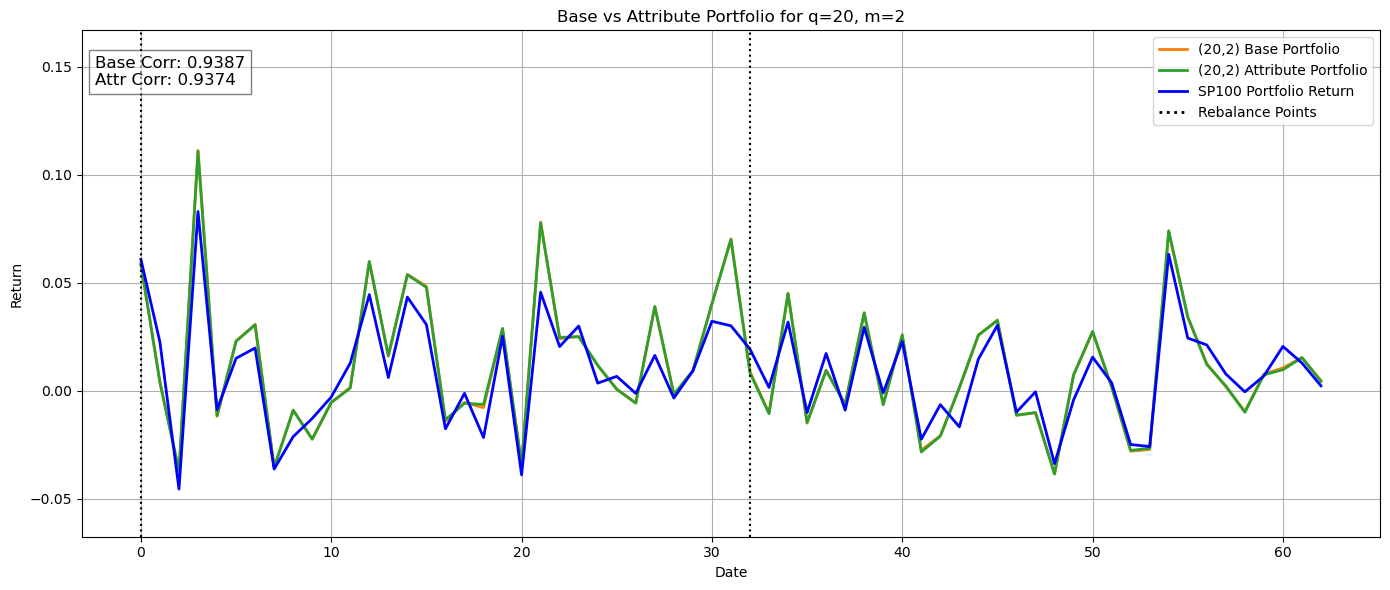

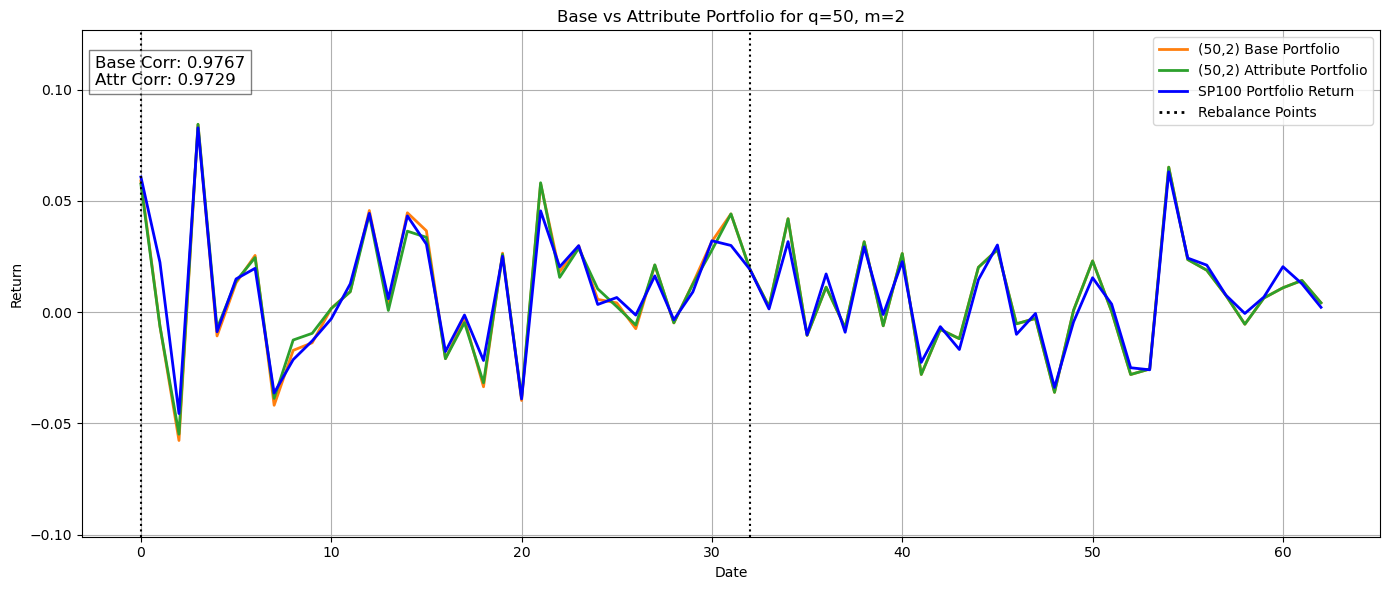

In [21]:
# Compare With attributes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.lines as mlines

# Read the data
corrs_df = pd.read_csv('data/mc_corr.csv')
indexes = pd.read_csv('data/mc_ret.csv')

# Load attribute-based data
att_corrs_df = pd.read_csv('data/att_corr.csv')
att_indexes = pd.read_csv('data/att_ret.csv')

# Group by q and find the best m for each q (highest correlation)
best_portfolios = corrs_df.loc[corrs_df.groupby('q')['Correlation'].idxmax()]

# Generate the labels for the best portfolios
top_labels = [f"({int(row.q)},{int(row.m)})" for _, row in best_portfolios.iterrows()]

# Plot the best portfolio for each q
for label in top_labels:
    focus_q, focus_m = eval(label)  # safe if coming from trusted source

    plt.figure(figsize=(14, 6))

    # Plot the original portfolio
    plt.plot(indexes.index, indexes[label], label=f'{label} Base Portfolio', linewidth=2, color='tab:orange')

    # Plot the attribute-based portfolio
    if label in att_indexes.columns:
        plt.plot(att_indexes.index, att_indexes[label], label=f'{label} Attribute Portfolio', linewidth=2, color='tab:green')

    # Plot SP100
    plt.plot(indexes.index, indexes['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='-', color='blue')

    # Rebalance lines
    rebalance_points = list(range(0, len(indexes), int(np.ceil(len(indexes) / focus_m))))
    for x in rebalance_points:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1.5)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=2, label='Rebalance Points')

    # Correlation annotations
    base_corr = corrs_df[(corrs_df['q'] == focus_q) & (corrs_df['m'] == focus_m)]['Correlation'].values[0]
    try:
        att_corr = att_corrs_df[(att_corrs_df['q'] == focus_q) & (att_corrs_df['m'] == focus_m)]['Correlation'].values[0]
        corr_text = f'Base Corr: {base_corr:.4f}\nAttr Corr: {att_corr:.4f}'
    except IndexError:
        corr_text = f'Base Corr: {base_corr:.4f}\nAttr Corr: N/A'

    plt.text(
        0.01, 0.95, corr_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Return')
    all_vals = pd.concat([indexes[label], att_indexes[label]] if label in att_indexes.columns else [indexes[label]])
    plt.ylim(all_vals.min() * 1.75, all_vals.max() * 1.5)
    plt.title(f'Base vs Attribute Portfolio for q={focus_q}, m={focus_m}')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


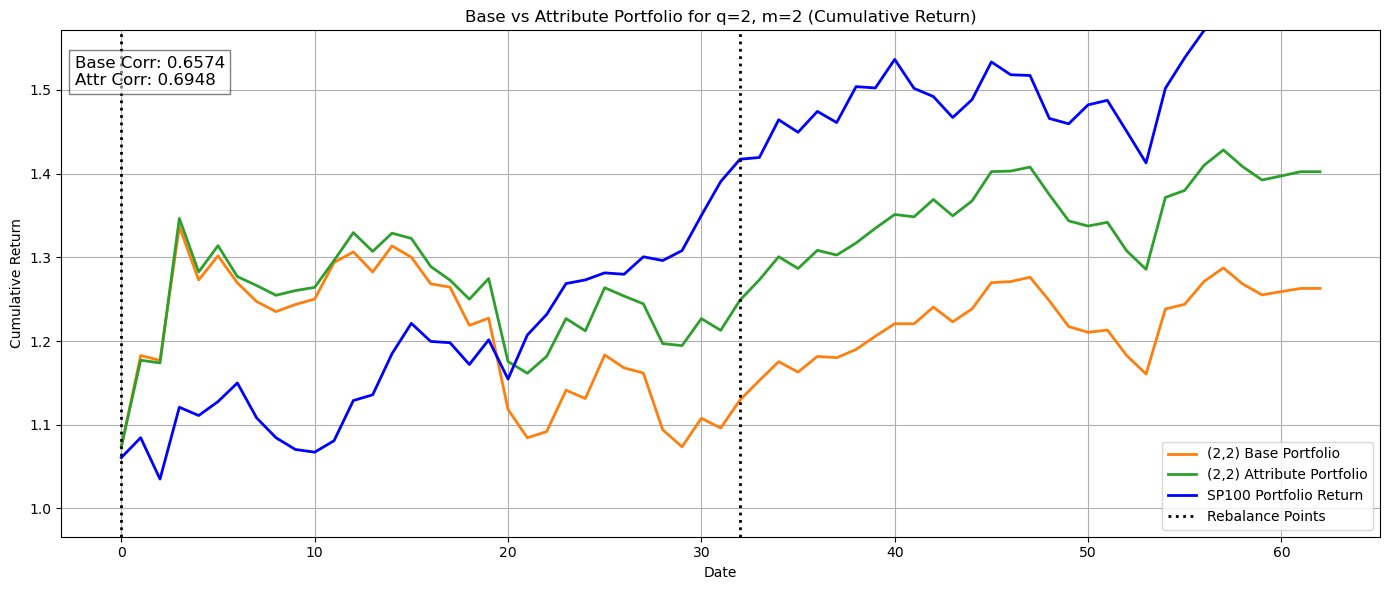

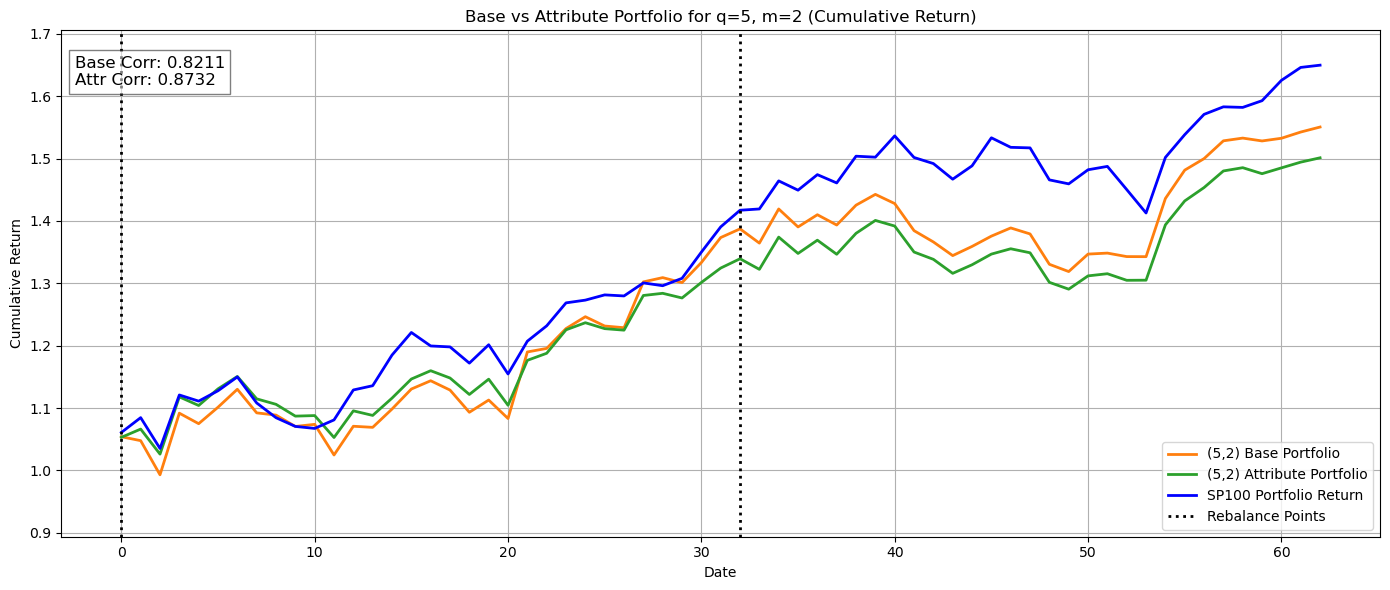

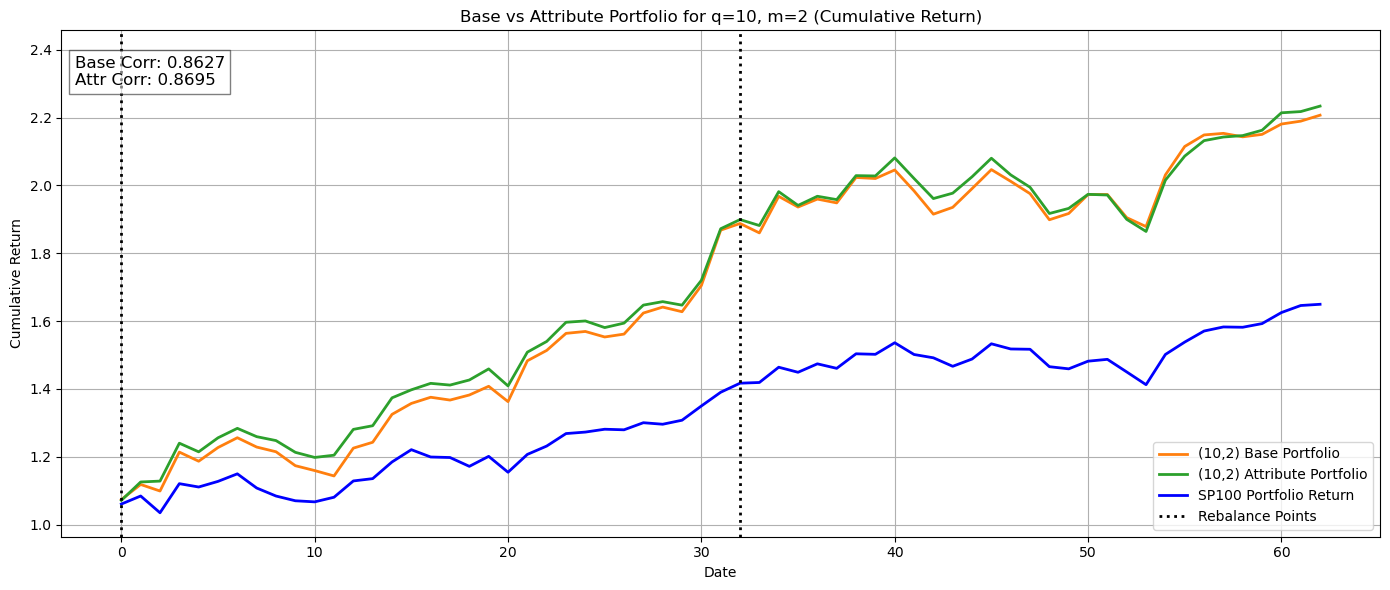

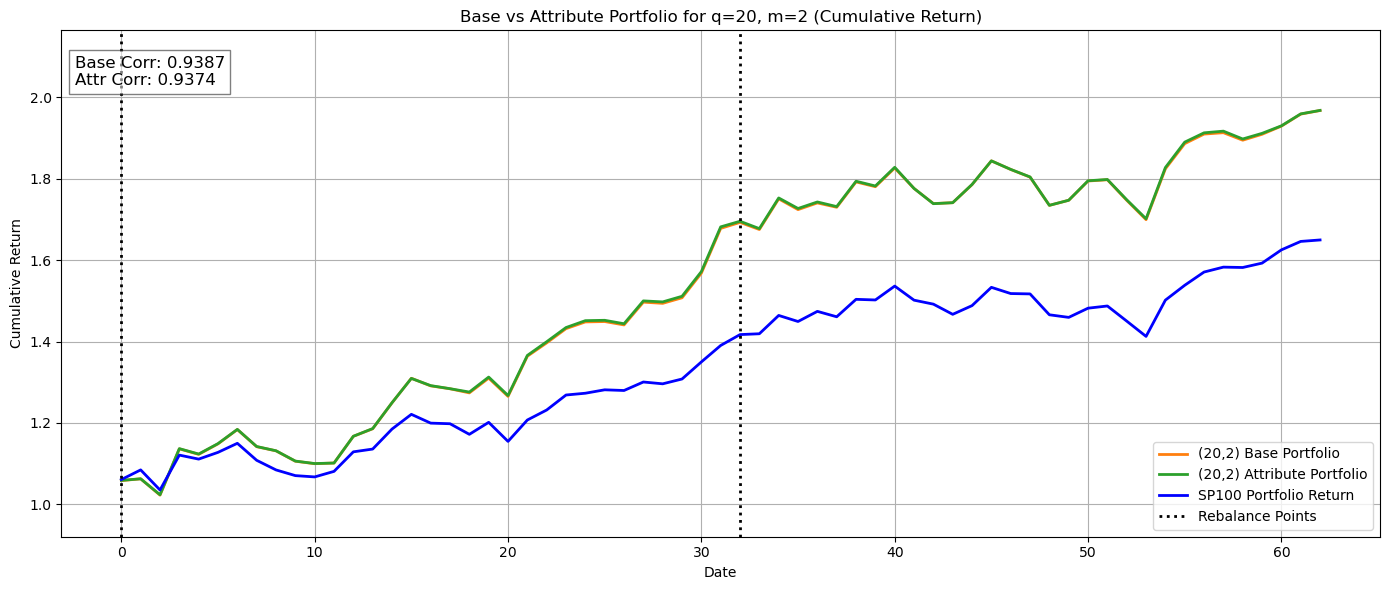

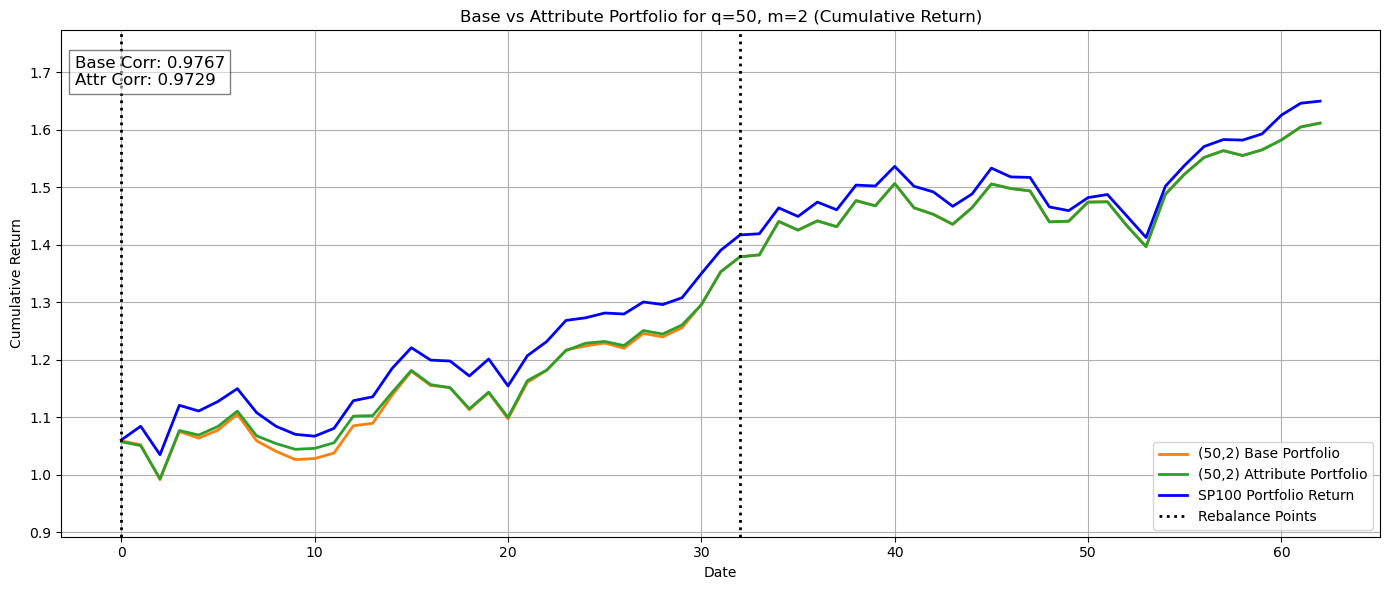

In [22]:
# Cumulative returns
cumulative_indexes = (1 + indexes).cumprod()
cumulative_att_indexes = (1 + att_indexes).cumprod()

# Best portfolios per q
best_portfolios = corrs_df.loc[corrs_df.groupby('q')['Correlation'].idxmax()]
top_labels = [f"({int(row.q)},{int(row.m)})" for _, row in best_portfolios.iterrows()]

# Plot
for label in top_labels:
    focus_q, focus_m = eval(label)

    plt.figure(figsize=(14, 6))

    # Plot base cumulative return
    plt.plot(cumulative_indexes.index, cumulative_indexes[label], label=f'{label} Base Portfolio', linewidth=2, color='tab:orange')

    # Plot attribute cumulative return if available
    if label in cumulative_att_indexes.columns:
        plt.plot(cumulative_att_indexes.index, cumulative_att_indexes[label], label=f'{label} Attribute Portfolio', linewidth=2, color='tab:green')

    # Plot SP100
    plt.plot(cumulative_indexes.index, cumulative_indexes['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='-', color='blue')

    # Rebalance lines
    rebalance_points = list(range(0, len(cumulative_indexes), int(np.ceil(len(cumulative_indexes) / focus_m))))
    for x in rebalance_points:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=2, label='Rebalance Points')

    # Correlations
    base_corr = corrs_df[(corrs_df['q'] == focus_q) & (corrs_df['m'] == focus_m)]['Correlation'].values[0]
    try:
        att_corr = att_corrs_df[(att_corrs_df['q'] == focus_q) & (att_corrs_df['m'] == focus_m)]['Correlation'].values[0]
        corr_text = f'Base Corr: {base_corr:.4f}\nAttr Corr: {att_corr:.4f}'
    except IndexError:
        corr_text = f'Base Corr: {base_corr:.4f}\nAttr Corr: N/A'

    plt.text(
        0.01, 0.95, corr_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Y-axis range based on both portfolios
    all_vals = pd.concat([
        cumulative_indexes[label],
        cumulative_att_indexes[label] if label in cumulative_att_indexes.columns else pd.Series()
    ], axis=0)
    plt.ylim(all_vals.min() * 0.9, all_vals.max() * 1.1)

    # Final touches
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f'Base vs Attribute Portfolio for q={focus_q}, m={focus_m} (Cumulative Return)')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

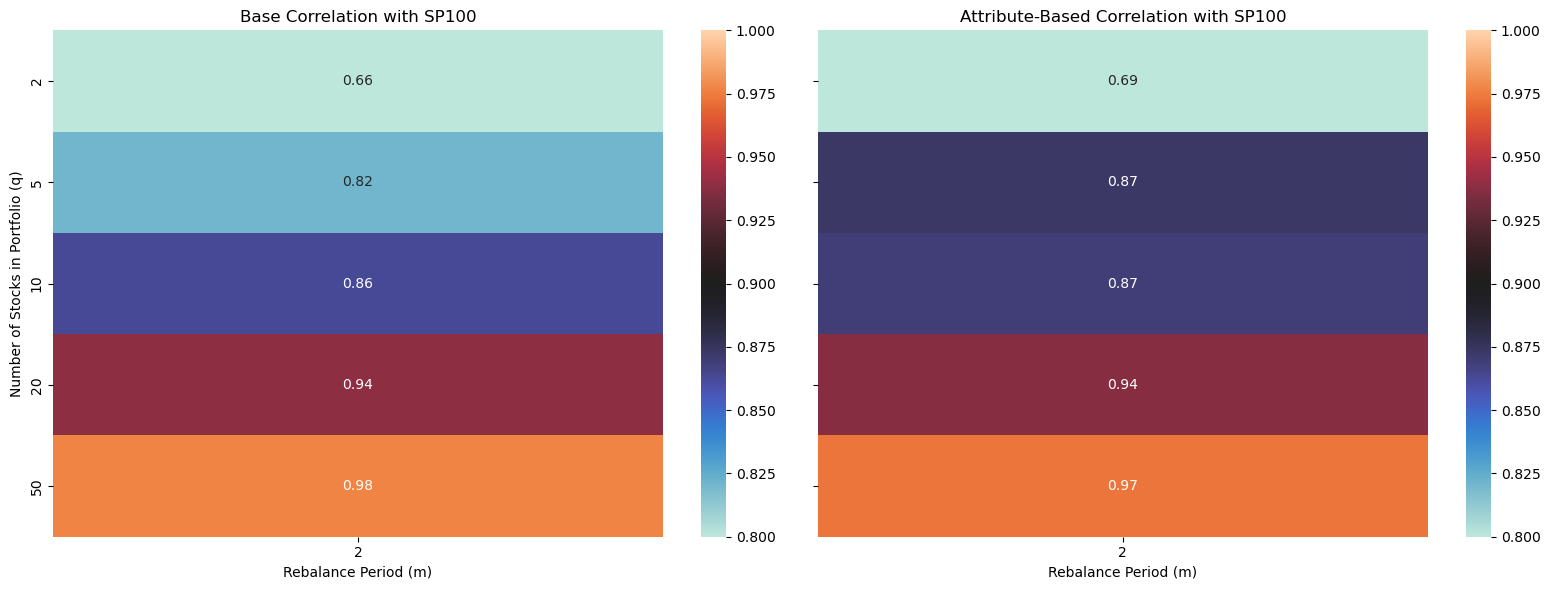

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot both dataframes
base_pivot = corrs_df.pivot(index='q', columns='m', values='Correlation')
att_pivot = att_corrs_df.pivot(index='q', columns='m', values='Correlation')

# Shared color scale parameters
vmin, vmax = 0.8, 1.0

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Base correlation heatmap
sns.heatmap(base_pivot, annot=True, fmt=".2f", center=0.9, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Base Correlation with SP100")
axes[0].set_xlabel("Rebalance Period (m)")
axes[0].set_ylabel("Number of Stocks in Portfolio (q)")

# Attribute correlation heatmap
sns.heatmap(att_pivot, annot=True, fmt=".2f", center=0.9, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Attribute-Based Correlation with SP100")
axes[1].set_xlabel("Rebalance Period (m)")
axes[1].set_ylabel("")  # Optional: remove for cleaner look

# Final layout
plt.tight_layout()
plt.show()


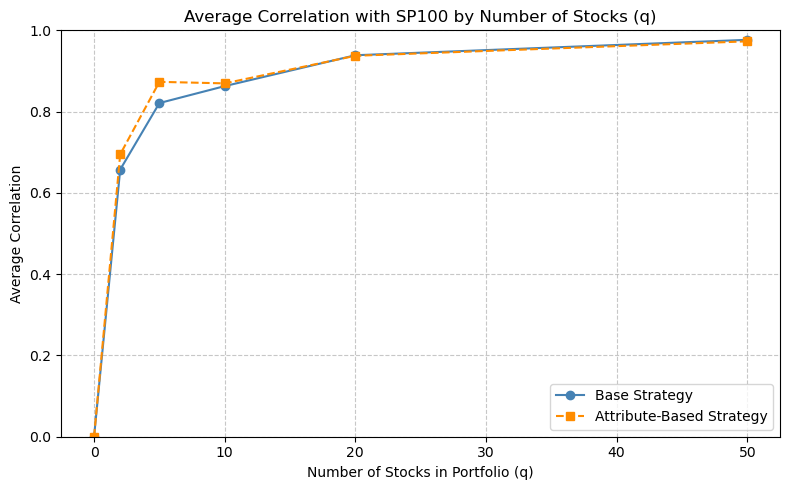

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute average correlations by q for both base and attribute-based
base_avg = corrs_df.groupby('q')['Correlation'].mean()
att_avg = att_corrs_df.groupby('q')['Correlation'].mean()

# Add (0, 0) to the beginning of both
base_avg = pd.concat([pd.Series({0: 0.0}), base_avg])
att_avg = pd.concat([pd.Series({0: 0.0}), att_avg])

# Sort index in case
base_avg = base_avg.sort_index()
att_avg = att_avg.sort_index()

# Line plot
plt.figure(figsize=(8, 5))
plt.plot(base_avg.index, base_avg.values, marker='o', linestyle='-', color='steelblue', label='Base Strategy')
plt.plot(att_avg.index, att_avg.values, marker='s', linestyle='--', color='darkorange', label='Attribute-Based Strategy')

plt.title('Average Correlation with SP100 by Number of Stocks (q)')
plt.xlabel('Number of Stocks in Portfolio (q)')
plt.ylabel('Average Correlation')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
